In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

RANDOM_STATE = 1234

In [2]:
train = pd.read_csv('D:/Titanic/titanic/train.csv')
test = pd.read_csv("D:/Titanic/titanic/test.csv")

In [3]:
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [4]:
train['Age'].fillna(value=train['Age'].mean(), inplace=True)

test['Age'].fillna(value=test['Age'].mean(), inplace=True)
test['Fare'].fillna(value=test['Fare'].mean(), inplace=True)

In [5]:
train.dropna()
test.dropna()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.50000,0,0,7.8292,Q
1,3,female,47.00000,1,0,7.0000,S
2,2,male,62.00000,0,0,9.6875,Q
3,3,male,27.00000,0,0,8.6625,S
4,3,female,22.00000,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,30.27259,0,0,8.0500,S
414,1,female,39.00000,0,0,108.9000,C
415,3,male,38.50000,0,0,7.2500,S
416,3,male,30.27259,0,0,8.0500,S


In [6]:
one_hot_columns = ['Embarked']

df_train = pd.get_dummies(data=train, prefix=one_hot_columns, columns=one_hot_columns, dtype=int)
df_train['Sex'] = (df_train['Sex'] == 'male').astype(int)

df_test = pd.get_dummies(data=test, prefix=one_hot_columns, columns=one_hot_columns, dtype=int)
df_test['Sex'] = (df_train['Sex'] == 'male').astype(int)

In [7]:
numerical_column = ['Age', 'Fare']
df_train[numerical_column] = StandardScaler().fit_transform(df_train[numerical_column])
df_test[numerical_column] = StandardScaler().fit_transform(df_test[numerical_column])

In [8]:
features = [x for x in df_train.columns if x not in 'Survived']

X_train, X_valid, y_train, y_valid = train_test_split(df_train[features], df_train['Survived'], train_size=0.8, random_state=RANDOM_STATE)

print('X train shape:', X_train.shape)
print('Y train shape:', y_train.shape)
print('X valid shape:', X_valid.shape)
print('Y valid shape:', y_valid.shape)

X train shape: (712, 9)
Y train shape: (712,)
X valid shape: (179, 9)
Y valid shape: (179,)


In [9]:
def base_model(learning_rate, lambda_, batch_size, epochs):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L1'),
    tf.keras.layers.Dense(units=15, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L2'),
    tf.keras.layers.Dense(units=1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L3')
  ])

  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'] 
  )

  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

  return model, history

In [10]:
def predict(model, X, y):
  yhat = model.predict(X)
  yhat = tf.math.sigmoid(yhat)
  yhat = (yhat.numpy() >= 0.5).astype(int)
  mse = mean_squared_error(yhat, y) / 2
  acc = accuracy_score(yhat, y)

  return mse, acc

In [11]:
def append_mse_acc(model, train_mse_list, train_acc_list, valid_mse_list, valid_acc_list):
  train_mse, train_acc = predict(model, X_train, y_train)
  train_mse_list.append(train_mse)
  train_acc_list.append(train_acc)

  valid_mse, valid_acc = predict(model, X_valid, y_valid)
  valid_mse_list.append(valid_mse)
  valid_acc_list.append(valid_acc)

  return train_mse_list, train_acc_list, valid_mse_list, valid_acc_list

In [12]:
def plot_mse_acc(train_mse_list, train_acc_list, valid_mse_list, valid_acc_list, x_list, tuning_name):
  fig, ax = plt.subplots(1, 2, figsize=(14, 4))

  ax[0].set_title(f'{tuning_name} MSE')
  ax[0].set_xticks(ticks=range(len(train_mse_list)), labels=x_list)
  ax[0].plot(train_mse_list, color='blue')
  ax[0].plot(valid_mse_list, color='red')
  ax[0].set_ylabel('MSE')
  ax[0].set_xlabel(f'{tuning_name}')
  ax[0].set_xlim(0, len(train_mse_list) - 1)
  ax[0].legend(['Training', 'Validation'])

  ax[1].set_title(f'{tuning_name} Accuracy')
  ax[1].set_xticks(ticks=range(len(train_mse_list)), labels=x_list)
  ax[1].plot(train_acc_list, color='blue')
  ax[1].plot(valid_acc_list, color='red')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel(f'{tuning_name}')
  ax[1].set_xlim(0, len(train_mse_list) - 1)
  ax[1].legend(['Training', 'Validation'])

  plt.tight_layout()
  plt.show()

  return fig, ax

In [13]:
learning_rate_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
l_train_mse, l_valid_mse = [], []
l_train_acc, l_valid_acc = [], []

for learning_rate in learning_rate_list:
  model, history = base_model(learning_rate=learning_rate, lambda_=0, batch_size=100, epochs=10)
  l_train_mse, l_train_acc, l_valid_mse, l_valid_acc = append_mse_acc(model, l_train_mse, l_train_acc, l_valid_mse, l_valid_acc)
optimal_learning_rate = learning_rate_list[np.argmin(l_valid_mse)]
print(optimal_learning_rate)

Epoch 1/10
8/8 [==============================] - 1s 2ms/step - loss: 0.7108 - accuracy: 0.5955
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7107 - accuracy: 0.5955
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7107 - accuracy: 0.5955
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7107 - accuracy: 0.5955
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7106 - accuracy: 0.5955
Epoch 6/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7106 - accuracy: 0.5955
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7106 - accuracy: 0.5955
Epoch 8/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7105 - accuracy: 0.5955
Epoch 9/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7105 - accuracy: 0.5955
Epoch 10/10
6/6 [==============================] - 0s 1ms/step
Epoch 1/10
8/8 [==============================] - 1s 2ms/step - loss: 0.8

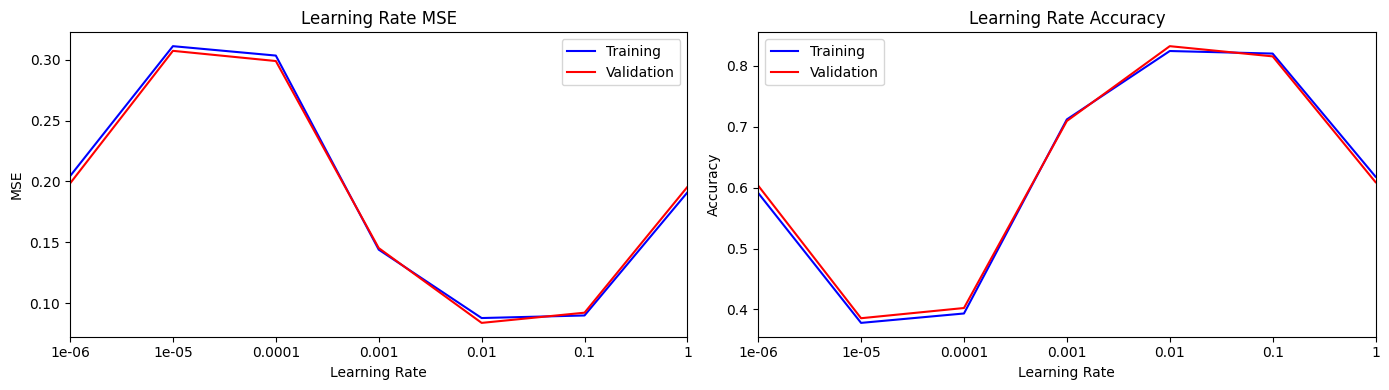

In [14]:
fig, ax = plot_mse_acc(l_train_mse, l_train_acc, l_valid_mse, l_valid_acc, learning_rate_list, 'Learning Rate')

In [15]:
lambda_list = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20, 30, 50, 100]
r_train_mse, r_valid_mse = [], []
r_train_acc, r_valid_acc = [], []

for lambda_ in lambda_list:
  model, history = base_model(learning_rate=0.001, lambda_=lambda_, batch_size=100, epochs=10)
  r_train_mse, r_train_acc, r_valid_mse, r_valid_acc = append_mse_acc(model, r_train_mse, r_train_acc, r_valid_mse, r_valid_acc)

Epoch 1/10
8/8 [==============================] - 1s 2ms/step - loss: 0.6639 - accuracy: 0.6081
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6505 - accuracy: 0.6067
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6388 - accuracy: 0.6124
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6285 - accuracy: 0.6124
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6188 - accuracy: 0.6180
Epoch 6/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6100 - accuracy: 0.6236
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6014 - accuracy: 0.6306
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5938 - accuracy: 0.6419
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5858 - accuracy: 0.6573
Epoch 10/10
6/6 [==============================] - 0s 1ms/step
Epoch 1/10
8/8 [==============================] - 1s 1ms/step - loss: 0.6

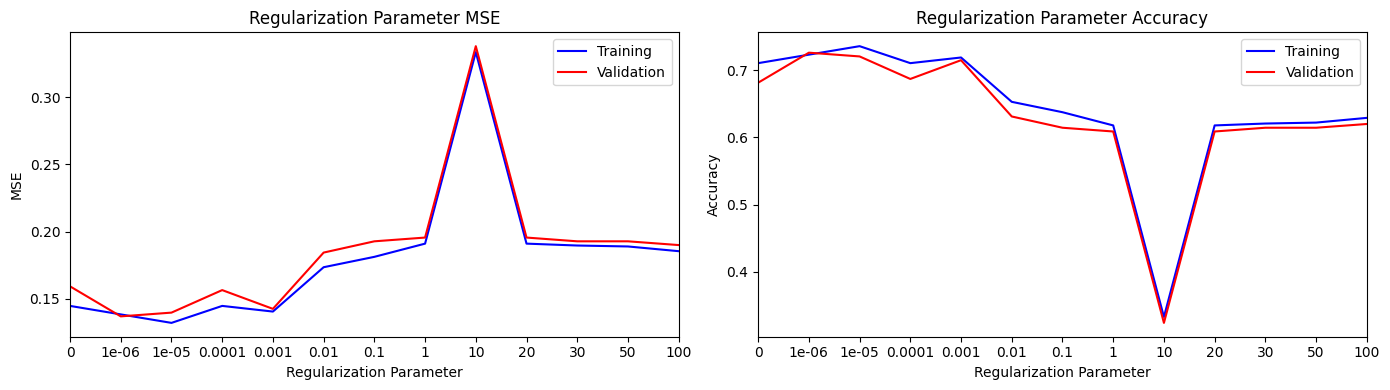

In [16]:
fig, ax = plot_mse_acc(r_train_mse, r_train_acc, r_valid_mse, r_valid_acc, lambda_list, 'Regularization Parameter')

In [17]:
batch_list = [50, 100, 150, 200, 250, 300, 400, 500]
b_train_mse, b_valid_mse = [], []
b_train_acc, b_valid_acc = [], []

for batch in batch_list:
  model, history = base_model(learning_rate=0.001, lambda_=10, batch_size=batch, epochs=10)
  b_train_mse, b_train_acc, b_valid_mse, b_valid_acc = append_mse_acc(model, b_train_mse, b_train_acc, b_valid_mse, b_valid_acc)

Epoch 1/10
15/15 [==============================] - 1s 2ms/step - loss: 348.3617 - accuracy: 0.6180
Epoch 2/10
15/15 [==============================] - 0s 2ms/step - loss: 309.1890 - accuracy: 0.6180
Epoch 3/10
15/15 [==============================] - 0s 2ms/step - loss: 273.8654 - accuracy: 0.6180
Epoch 4/10
15/15 [==============================] - 0s 2ms/step - loss: 242.2769 - accuracy: 0.6180
Epoch 5/10
15/15 [==============================] - 0s 2ms/step - loss: 214.1262 - accuracy: 0.6180
Epoch 6/10
15/15 [==============================] - 0s 2ms/step - loss: 189.0769 - accuracy: 0.6180
Epoch 7/10
15/15 [==============================] - 0s 2ms/step - loss: 166.8061 - accuracy: 0.6180
Epoch 8/10
15/15 [==============================] - 0s 2ms/step - loss: 147.0202 - accuracy: 0.6180
Epoch 9/10
15/15 [==============================] - 0s 2ms/step - loss: 129.4543 - accuracy: 0.6180
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
Epoch 1/10
8/8 [=====================

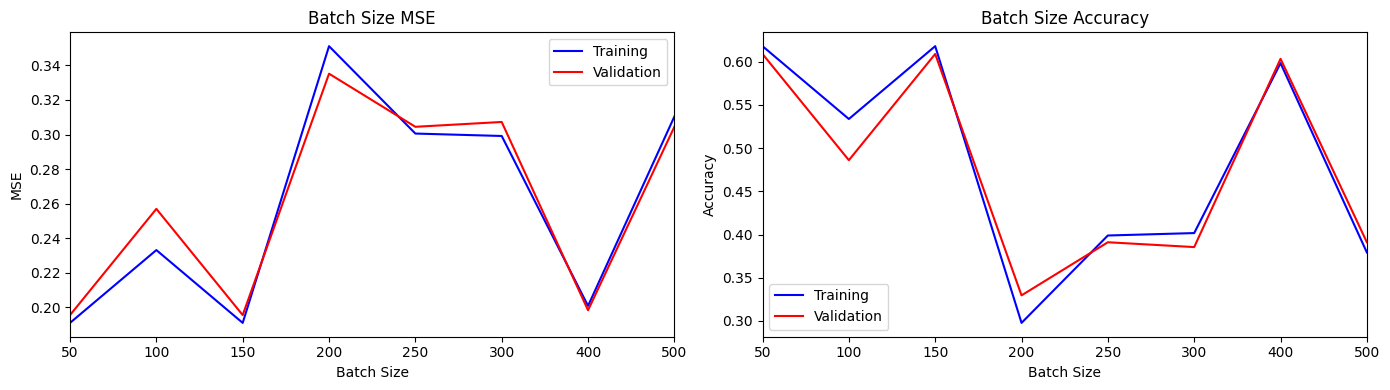

In [18]:
fig, ax = plot_mse_acc(b_train_mse, b_train_acc, b_valid_mse, b_valid_acc, batch_list, 'Batch Size')

In [19]:
epochs_list = [10, 20, 30, 50, 70, 100, 150, 200, 250, 300]
e_train_mse, e_valid_mse = [], []
e_train_acc, e_valid_acc = [], []

for epoch in epochs_list:
  model, history = base_model(learning_rate=0.001, lambda_=10, batch_size=300, epochs=epoch)
  e_train_mse, e_train_acc, e_valid_mse, e_valid_acc = append_mse_acc(model, e_train_mse, e_train_acc, e_valid_mse, e_valid_acc)

Epoch 1/10
3/3 [==============================] - 1s 3ms/step - loss: 345.0773 - accuracy: 0.6180
Epoch 2/10
3/3 [==============================] - 0s 3ms/step - loss: 336.9741 - accuracy: 0.6180
Epoch 3/10
3/3 [==============================] - 0s 2ms/step - loss: 329.0115 - accuracy: 0.6180
Epoch 4/10
3/3 [==============================] - 0s 3ms/step - loss: 321.1943 - accuracy: 0.6180
Epoch 5/10
3/3 [==============================] - 0s 15ms/step - loss: 313.5259 - accuracy: 0.6180
Epoch 6/10
3/3 [==============================] - 0s 5ms/step - loss: 306.0091 - accuracy: 0.6180
Epoch 7/10
3/3 [==============================] - 0s 4ms/step - loss: 298.6453 - accuracy: 0.6180
Epoch 8/10
3/3 [==============================] - 0s 2ms/step - loss: 291.4357 - accuracy: 0.6180
Epoch 9/10
3/3 [==============================] - 0s 3ms/step - loss: 284.3804 - accuracy: 0.6180
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
Epoch 1/20
3/3 [==============================] - 1s 3

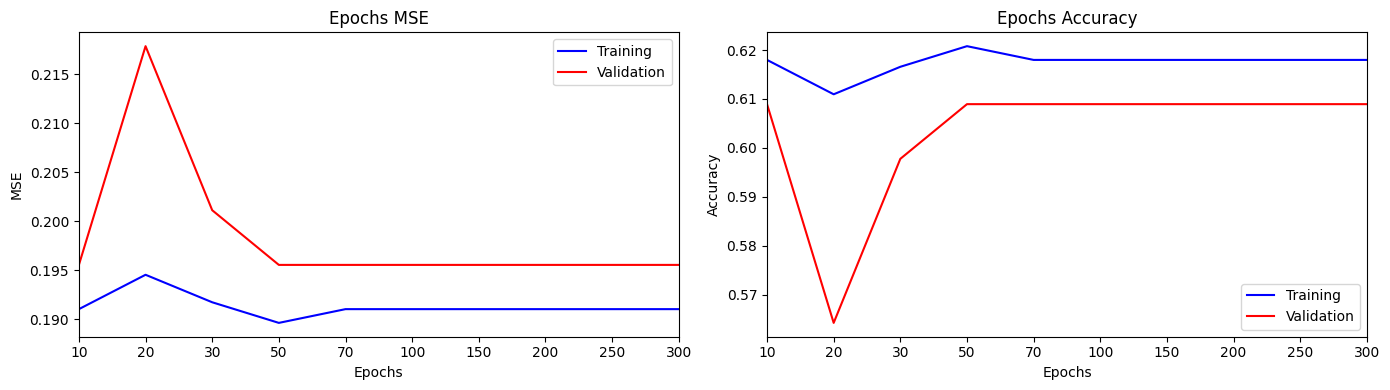

In [20]:
fig, ax = plot_mse_acc(e_train_mse, e_train_acc, e_valid_mse, e_valid_acc, epochs_list, 'Epochs')

In [21]:
model, history = base_model(learning_rate=0.01, lambda_=1e-5, batch_size=100, epochs=30)

Epoch 1/30
8/8 [==============================] - 1s 2ms/step - loss: 0.6262 - accuracy: 0.6096
Epoch 2/30
8/8 [==============================] - 0s 2ms/step - loss: 0.5477 - accuracy: 0.6503
Epoch 3/30
8/8 [==============================] - 0s 2ms/step - loss: 0.5119 - accuracy: 0.6994
Epoch 4/30
8/8 [==============================] - 0s 2ms/step - loss: 0.4805 - accuracy: 0.7303
Epoch 5/30
8/8 [==============================] - 0s 2ms/step - loss: 0.4611 - accuracy: 0.7697
Epoch 6/30
8/8 [==============================] - 0s 2ms/step - loss: 0.4518 - accuracy: 0.8104
Epoch 7/30
8/8 [==============================] - 0s 2ms/step - loss: 0.4544 - accuracy: 0.7963
Epoch 8/30
8/8 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.7921
Epoch 9/30
8/8 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.8230
Epoch 10/30
8/8 [==============================] - 0s 2ms/step - loss: 0.4276 - accuracy: 0.8301
Epoch 11/30
8/8 [======================

In [22]:
yhat_train = model.predict(X_train)
yhat_train = tf.math.sigmoid(yhat_train)
yhat_train = (yhat_train.numpy() >= 0.5).astype(int)
acc_train = accuracy_score(yhat_train, y_train)

yhat_valid = model.predict(X_valid)
yhat_valid = tf.math.sigmoid(yhat_valid)
yhat_valid = (yhat_valid.numpy() >= 0.5).astype(int)
acc_valid = accuracy_score(yhat_valid, y_valid)

6/6 [==============================] - 0s 1ms/step


In [23]:
print(f"Metrics train:\n\tAccuracy score: {acc_train:0.4f}")
print(f"Metrics validation:\n\tAccuracy score: {acc_valid:0.4f}")

Metrics train:
	Accuracy score: 0.8455
Metrics validation:
	Accuracy score: 0.8156


In [24]:
results = model.predict(df_test)
results = tf.math.sigmoid(results)
results = (results.numpy() >= 0.5).astype(int)
results = np.reshape(results, (-1, ))
results = pd.Series(data=results, name='Survived')

14/14 [==============================] - 0s 1ms/step


In [25]:
# submission = pd.concat([pd.Series(range(892, 1309), name='PassengerId'), results], axis=1)
# submission.to_csv('submit.csv', index=False)

In [26]:
def create_model(lambda_=1e-4, learning_rate=1e-4):
    model = Sequential([
        Dense(units=30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L1', input_dim=X_train.shape[1]),
        Dense(units=15, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L2'),
        Dense(units=1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L3')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])

    return model

In [27]:
model = KerasClassifier(model=create_model,
                             epochs=None,
                             batch_size=None,
                             lambda_=None,
                             learning_rate=None)

param_grid = {
  "epochs": [20, 30, 50],
  "batch_size": [50, 100, 150],
  "lambda_": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20, 30],
  "learning_rate": [1e-4, 1e-3, 2, 1e-1, 1]
}

grid = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring=["accuracy"],
                           cv=3,
                           verbose=1,
                           return_train_score=True)
grid_result = grid.fit(X_train, y_train)

ValueError: For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit an estimator with the best parameter setting on the whole data and make the best_* attributes available for that metric. If this is not needed, refit should be set to False explicitly. True was passed.